In [1]:

# importing modules


import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

In [2]:
# setting hyperparameters


img_size = 32
batch_size = 100
num_threads = 8
lat_dim = 32
lr = 1e-4
n_epoch = 10
beta = 250

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [170]:
# data loader for CelebA dataset


def CelabA_loader():
    # For cropped image, use the below transform
    #transform = transforms.Compose([transforms.CenterCrop(size=(170, 130)), transforms.Resize(size=(img_size, img_size)), transforms.ToTensor()])
    transform = transforms.Compose([transforms.Resize(size=(img_size, img_size)), transforms.ToTensor()])
    dataset = torchvision.datasets.ImageFolder(root='data/celebA/', transform=transform)
    
    train_data = torchvision.datasets.ImageFolder(root='data/celebA/', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads, drop_last=True)
    test_data = torchvision.datasets.ImageFolder(root='data/celebA/', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_threads, drop_last=True)
    return train_loader, test_loader

In [171]:
a, b = CelabA_loader()
for x in a:
    print(x)
    break

Dataset ImageFolder
    Number of datapoints: 100
    Root location: data/celebA/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
[tensor([[[[0.0784, 0.0824, 0.0863,  ..., 0.7137, 0.6706, 0.7412],
          [0.0784, 0.0824, 0.0863,  ..., 0.7059, 0.6784, 0.7373],
          [0.0784, 0.0824, 0.0824,  ..., 0.7098, 0.6745, 0.7412],
          ...,
          [0.7647, 0.7569, 0.7569,  ..., 0.2471, 0.3216, 0.3725],
          [0.7647, 0.7608, 0.7608,  ..., 0.1765, 0.1451, 0.1647],
          [0.7725, 0.7647, 0.7608,  ..., 0.1647, 0.1176, 0.1333]],

         [[0.1569, 0.1647, 0.1686,  ..., 0.4824, 0.1843, 0.5098],
          [0.1569, 0.1647, 0.1686,  ..., 0.4471, 0.1882, 0.5529],
          [0.1569, 0.1647, 0.1686,  ..., 0.4118, 0.1961, 0.5922],
          ...,
          [0.7490, 0.7412, 0.7412,  ..., 0.2471, 0.3216, 0.3725],
          [0.7490, 0.7451, 0.7451,  ..., 0.1804, 0.1451, 0.1608],
       

In [87]:
# util function mostly for visualization purpose


def plot_ELBO_curve(generated, train_list, test_list):
    fig = plt.figure()       
    plt.plot(train_list, 'r-', label='train ELBO')
    plt.plot(test_list, 'r--', label='test ELBO')
    plt.legend()
    plt.savefig('plots/'+generated+'/ELBO_curves.png')
    plt.close()

def plot_test_images(sample_hat, generated, n, height=img_size, width=img_size):
    sample_hat = sample_hat.view(-1, 3, height, width)
    grid = save_image(sample_hat, filename="plots/"+generated+"/test_images.png", nrow=n, padding=0)
    
def plot_latent_traverse(model, image_size, traverse_dim, generated, z_mu, intNumX1=7, n=5):
    x1s = np.linspace(-3.0, 3.0, intNumX1, dtype=np.float32)
    dist = torch.distributions.normal.Normal(loc=0, scale=1)    
    canvas = np.zeros((image_size * n, image_size * intNumX1, 3))
    
    for j in range(n):
        for i, x1 in enumerate(x1s):
            z_mu[j][traverse_dim] = torch.Tensor([x1])
            z_mu = z_mu.to(device)
            z = model(z_mu[j]).detach().to(torch.device("cpu"))
            z = z.view(3, image_size, image_size)
            z = z.permute(1,2,0).numpy()
            canvas[image_size*(n-j-1):image_size*(n-j), image_size*i:image_size*(i+1), :] = z

    plt.figure(figsize=(8, 6))
    plt.imshow(canvas)
    plt.tight_layout()
    plt.savefig("plots/"+generated+"/latent/latent_traverses_{}.png".format(traverse_dim), bbox_inches='tight')
    plt.close()


In [95]:
# BetaVAE model structure


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE(nn.Module):
    def __init__(self, generated='Gaussian', mode='learn'):
        super(BetaVAE, self).__init__()
        self.generated = generated
        self.mode = mode
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(nn.Conv2d(3, 32, 4, stride=2, padding=1),  # B*32*32*32
                                     nn.ReLU(),
                                     nn.Conv2d(32, 32, 4, stride=2, padding=1),  # B*32*16*16
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, 4, stride=2, padding=1),  # B*64*8*8
                                     nn.ReLU(),
                                     nn.Conv2d(64, 64, 4, stride=2, padding=1),  # B*64*4*4
                                     nn.ReLU(),
                                     nn.Conv2d(64, 256, 4),  # B*256*1*1
                                     nn.ReLU(),
                                     View(size=(-1, 256)),  # B*256
                                     nn.Linear(256, lat_dim*2))

        self.decoder = nn.Sequential(nn.Linear(lat_dim, 256),
                                     View((-1, 256, 1, 1)),  # B*256*1*1
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(256, 64, 4),  # B*64*4*4
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),  # B*64*8*8
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # B*32*16*16
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # B*32*32*32
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 6, 4, stride=2, padding=1))   # B*6*64*64

    def reparametrize(self, z_mu, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn(std.size()).to(device)
        return z_mu + std * eps

    def encoderNet(self, x):
        code = self.encoder(x)
        z_mu = code[:, :lat_dim]
        z_log_var = code[:, lat_dim:]
        z = self.reparametrize(z_mu, z_log_var)
        self.kl = -0.5 * ((1 + z_log_var) - z_mu * z_mu - torch.exp(z_log_var)).mean(dim=0).sum()
        return z

    def decoderNet(self, z):
        h = self.decoder(z)
        if self.generated == 'Bernoulli':
            h_ = h[:, :3, :, :]  
            self.x_ = self.sigmoid(h_)
            
        elif self.generated == 'Gaussian':
            x_mu = h[:, :3, :, :]
            x_log_var = h[:, 3:, :, :]
            x_std = torch.exp(0.5 * x_log_var)
            self.dist = torch.distributions.normal.Normal(loc=x_mu, scale=x_std)
            self.x_ = self.dist.sample()
            # For cleaner output, use below mu_estimation
            #self.x_ = x_mu 

    def forward(self, x):
        if self.mode == 'learn':
            self.z = self.encoderNet(x)
            self.decoderNet(self.z)
            if self.generated == 'Bernoulli':
                self.recon = -(x * torch.log(self.x_ + 1e-10) + (1 - x) * torch.log(1 - self.x_ + 1e-10)).mean(dim=0).sum()
            elif self.generated == 'Gaussian':
                self.recon = -self.dist.log_prob(x).mean(dim=0).sum()
            return self.x_, self.recon, self.kl

        elif self.mode == 'generate':
            self.decoderNet(x)
            return self.x_

In [96]:
# main function that is for training the model


def CelebA_main(dist='Gaussian'):
    train_loader, test_loader = CelabA_loader()
    model = BetaVAE(generated=dist).to(device)
    model.load_state_dict(torch.load('models/'+dist+'/BetaVAE.pt'))    
    model.mode = 'learn'
    #for name, param in model.named_parameters():
    #    if param.requires_grad:
    #        print(name)
    
    train_list, test_list = [], []
    
    for epoch in range(n_epoch):
        #if (epoch+1) % 200 == 0:
        #    lr = lr * 0.1
        #    print('current learning rate is ', lr)
        optimizer = optim.Adagrad(model.parameters(), lr=lr)
        
        train_loss, recon_err, kl_div, test_loss = 0.0, 0.0, 0.0, 0.0
        cnt = 0
        for x, y in train_loader:
            plt.imshow(x[0].permute(1,2,0))
            
            cnt += 1
            inputs = x.to(device)
            new_batch_size = x.size()[0]
            inputs = inputs.view(new_batch_size, -1, img_size, img_size)
            
            _, recon, kl = model(inputs)
            loss = recon + beta * kl
            
            train_loss += loss * new_batch_size / batch_size
            recon_err += recon * new_batch_size / batch_size
            kl_div += kl * new_batch_size / batch_size
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
      
        train_loss = train_loss / cnt
        recon_err = recon_err / cnt
        kl_div = kl_div / cnt
        
        train_list.append(-train_loss)
'''
        with torch.no_grad():
            cnt = 0
            for x, y in test_loader:
                cnt += 1
                model.eval()
                inputs = x.to(device)
                new_batch_size = x.size()[0]
                inputs = inputs.view(new_batch_size, -1, img_size, img_size)
            
                _, recon, kl = model(inputs)
                loss = recon + beta * kl
           
                test_loss += loss * new_batch_size / batch_size

            test_loss = test_loss / cnt
            test_list.append(-test_loss)
        
        torch.save(model.state_dict(), 'models/'+dist+'/BetaVAE.pt')
      
        if (epoch+1) % 1 == 0:
            print('[Epoch %d] train_loss: %.3f, recon_err: %.3f, kl_div: %.3f, test_loss: %.3f'
                  % (epoch+1, train_loss, recon_err, kl_div, test_loss))
                
    torch.save(inputs, 'data/celebA/samples.pt')
    
    sample = inputs
    sample_hat, _, _ = model(sample)
            
    plot_test_images(sample_hat.detach(), model.generated, n=10)
    
    plot_ELBO_curve(model.generated, train_list, test_list)
'''

"\n        with torch.no_grad():\n            cnt = 0\n            for x, y in test_loader:\n                cnt += 1\n                model.eval()\n                inputs = x.to(device)\n                new_batch_size = x.size()[0]\n                inputs = inputs.view(new_batch_size, -1, img_size, img_size)\n            \n                _, recon, kl = model(inputs)\n                loss = recon + beta * kl\n           \n                test_loss += loss * new_batch_size / batch_size\n\n            test_loss = test_loss / cnt\n            test_list.append(-test_loss)\n        \n        torch.save(model.state_dict(), 'models/'+dist+'/BetaVAE.pt')\n      \n        if (epoch+1) % 1 == 0:\n            print('[Epoch %d] train_loss: %.3f, recon_err: %.3f, kl_div: %.3f, test_loss: %.3f'\n                  % (epoch+1, train_loss, recon_err, kl_div, test_loss))\n                \n    torch.save(inputs, 'data/celebA/samples.pt')\n    \n    sample = inputs\n    sample_hat, _, _ = model(sample)\

cuda:1


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

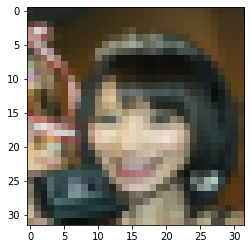

In [97]:
# running part for training BetaVAE model with CelebA dataset


if __name__ == '__main__': 
    print(device)
    lr = 1e-4
    n_epoch = 1
    CelebA_main()

In [ ]:
# 1st experiment : drawing a latent traverse of BetaVAE


if __name__ == '__main__': 
    print(device)
    model = BetaVAE('Gaussian').to(device)
    model.load_state_dict(torch.load('models/Gaussian/BetaVAE_Crop.pt'))

    sample = torch.load('data/celebA/samples.pt')

    for i in range(lat_dim):    
        model.mode = 'generate'
        z_mu = model.encoderNet(sample)
        plot_latent_traverse(model, img_size, i, model.generated, z_mu)
